##### TP integrador
Download Dataset here:
[Buenos Aires public bike system](https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download)



In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import HTML


In [18]:
HTML('<a href="https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download" target="_blank">Download Dataset</a>')

In [2]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

In [4]:
df.head()
#df.info()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais
0,15728,26/05/2018 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina
1,26531,26/05/2018 3:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina
2,161323,26/05/2018 18:52:19,0:12:00,Aime Paine,151,Retiro II,130,M,44.0,olga cossettini,NaN
3,239148,26/05/2018 13:19:34,1:26:30,Galerías Pacífico,34,Juana Manso,26,M,36.0,larrea,NaN
4,260323,26/05/2018 8:41:53,0:11:29,Virrey Cevallos,183,Corrientes,132,M,26.0,chacabuco,NaN


In [5]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

In [6]:
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))

In [9]:
df['date_no_hour'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(hour=0, minute=0, second=0))

In [11]:
df.head()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais,date,date_no_hour
0,15728,2018-05-26 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina,2018-05-26 15:00:00,2018-05-26
1,26531,2018-05-26 03:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina,2018-05-26 03:00:00,2018-05-26
2,161323,2018-05-26 18:52:19,0:12:00,Aime Paine,151,Retiro II,130,M,44.0,olga cossettini,NaN,2018-05-26 18:00:00,2018-05-26
3,239148,2018-05-26 13:19:34,1:26:30,Galerías Pacífico,34,Juana Manso,26,M,36.0,larrea,NaN,2018-05-26 13:00:00,2018-05-26
4,260323,2018-05-26 08:41:53,0:11:29,Virrey Cevallos,183,Corrientes,132,M,26.0,chacabuco,NaN,2018-05-26 08:00:00,2018-05-26


<Axes: xlabel='date'>

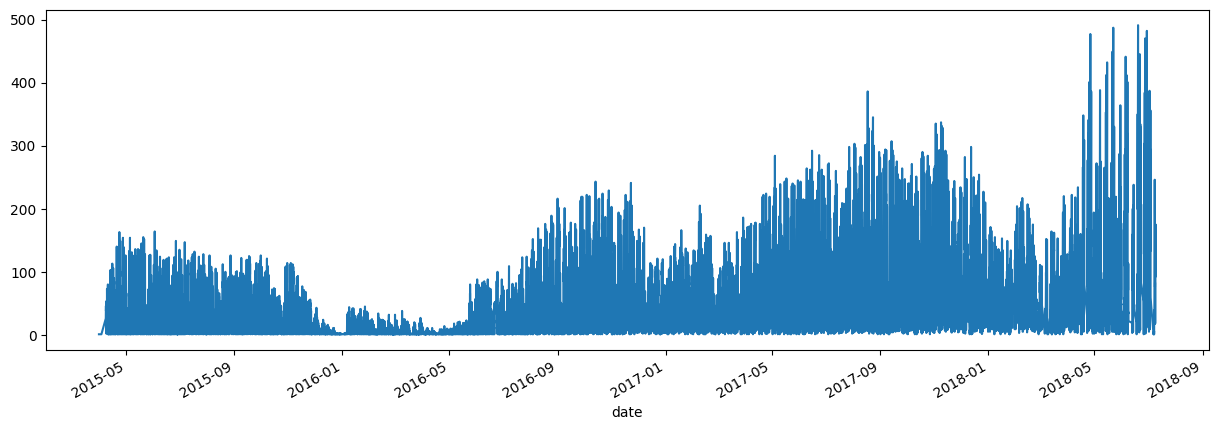

In [7]:
plt.figure(figsize=(15,5))
df.groupby('date').bici_id_usuario.count().plot()

In [14]:
s = df.groupby('date').bici_id_usuario.count()

<Axes: xlabel='date'>

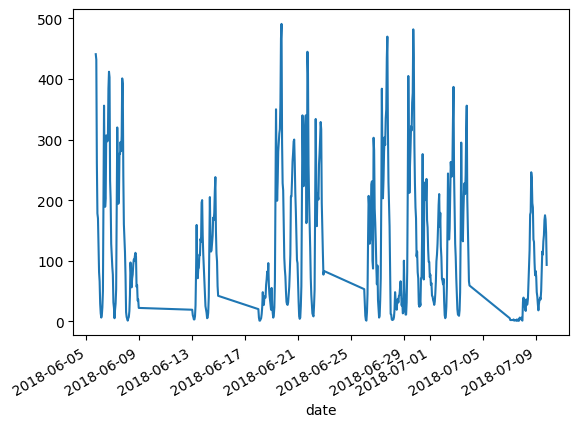

In [16]:
# últimos 500
s[-500:].plot()

In [19]:
a = s.reset_index()

In [20]:
a

,date,bici_id_usuario
0,2015-03-31 14:00:00,1
1,2015-04-03 09:00:00,1
2,2015-04-08 08:00:00,26
3,2015-04-08 09:00:00,42
4,2015-04-08 10:00:00,27
...,...,...
25643,2018-07-09 15:00:00,167
25644,2018-07-09 16:00:00,175
25645,2018-07-09 17:00:00,168
25646,2018-07-09 18:00:00,146


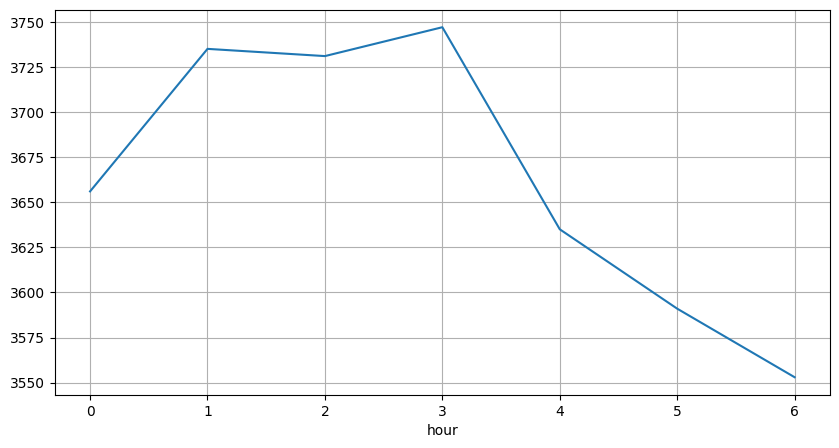

In [26]:
# Visualización por día de la semana

plt.figure(figsize=(10,5))
a = s.reset_index()
a['hour'] = a.date.apply(lambda x: x.weekday())
a.groupby('hour').bici_id_usuario.count().plot()
plt.xticks(list(range(7)))
plt.grid()
